In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import torch

from glob import glob

import IPython.display as ipd
from tqdm import tqdm

import subprocess as sp

plt.style.use('ggplot')

from useful_fn import *

In [9]:
def display_img(img, rgb=False, figsize=(15, 15)):
    if rgb:
        img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_ = img.copy()
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    #ax.axis("off")

In [2]:
img_name = "frame_0000.jpeg"

In [3]:
img = cv2.imread(f"train/{img_name}")

In [6]:
witdh = 640
height = 480

In [7]:
categories_map = { 
    0: "person", 
    1: "bicycle", 
    2: "car", 
    3: "motorcycle", 
    5: "bus" }

annotations = get_annotations("train", witdh, height, categories_map)

In [8]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
classes = { "0": "person", "1": "bicycle", "2": "car", "3": "motorcycle", "5": "bus" }


color_map = {
    0: (0,0,255), # blue
    1: (0, 255, 255), # cyan 
    2: (255, 128, 0), # orange 
    3: (128, 0, 255), # purple 
    5: (255, 0, 255), # magenta 
}

# yellow: 255,255,0 -> collision zone
# red: 255,0,0 -> person in collision zone

def predict_as_df(img, conf_thres):
    results = model(img)
    df = results.pandas().xyxy[0]
    df = df[df["name"].isin(list(classes.values()))]
    df = df[df['confidence'] >= conf_thres]
    return df 

Using cache found in /home/maxi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-2 Python-3.10.4 torch-1.13.1+cu117 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [24]:
predict_as_df(img, 0.5)

,xmin,ymin,xmax,ymax,confidence,class,name
0,485.635559,286.264282,606.127380,351.430664,0.734636,2,car
2,371.640961,204.327942,387.101898,240.469360,0.651189,0,person
3,246.865234,222.046341,263.271881,256.820435,0.622969,0,person
4,224.318405,206.681839,239.053391,244.418625,0.595744,0,person
5,469.392395,200.410721,487.201904,239.306381,0.562052,0,person
6,397.993988,208.227203,416.785187,245.276215,0.541336,0,person
7,381.765137,202.715958,393.762329,239.016006,0.521850,0,person


In [79]:
results = model(img)
labels, cord_thres = results.xyxyn[0][:, -1].numpy(), results.xyxyn[0][:, :-1].numpy()
pred_df = pd.DataFrame()
pred_df["xmin"] = results.xyxy[0][:,0].numpy().astype(np.int16)
pred_df["ymin"] = results.xyxy[0][:,1].numpy().astype(np.int16)
pred_df["xmax"] = results.xyxy[0][:,2].numpy().astype(np.int16)
pred_df["ymax"] = results.xyxy[0][:,3].numpy().astype(np.int16)
pred_df["confidence"] = results.xyxy[0][:,4].numpy().astype(np.float32)
pred_df["class"] = results.xyxy[0][:,5].numpy().astype(np.int8)

pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   xmin        19 non-null     int16  
 1   ymin        19 non-null     int16  
 2   xmax        19 non-null     int16  
 3   ymax        19 non-null     int16  
 4   confidence  19 non-null     float32
 5   class       19 non-null     int8   
dtypes: float32(1), int16(4), int8(1)
memory usage: 375.0 bytes


In [77]:
pred_df

,xmin,ymin,xmax,ymax,confidence,class
0,485,286,606,351,0.73,2
1,39,283,140,343,0.71,8
2,371,204,387,240,0.65,0
3,246,222,263,256,0.62,0
4,224,206,239,244,0.60,0
5,469,200,487,239,0.56,0
6,397,208,416,245,0.54,0
7,381,202,393,239,0.52,0
8,232,398,264,440,0.43,58
9,279,201,292,235,0.41,0


In [57]:
results.xyxy[0]

tensor([[4.85636e+02, 2.86264e+02, 6.06127e+02, 3.51431e+02, 7.34636e-01, 2.00000e+00],
        [3.96161e+01, 2.83618e+02, 1.40056e+02, 3.43917e+02, 7.05509e-01, 8.00000e+00],
        [3.71641e+02, 2.04328e+02, 3.87102e+02, 2.40469e+02, 6.51189e-01, 0.00000e+00],
        [2.46865e+02, 2.22046e+02, 2.63272e+02, 2.56820e+02, 6.22969e-01, 0.00000e+00],
        [2.24318e+02, 2.06682e+02, 2.39053e+02, 2.44419e+02, 5.95744e-01, 0.00000e+00],
        [4.69392e+02, 2.00411e+02, 4.87202e+02, 2.39306e+02, 5.62052e-01, 0.00000e+00],
        [3.97994e+02, 2.08227e+02, 4.16785e+02, 2.45276e+02, 5.41336e-01, 0.00000e+00],
        [3.81765e+02, 2.02716e+02, 3.93762e+02, 2.39016e+02, 5.21850e-01, 0.00000e+00],
        [2.32438e+02, 3.98645e+02, 2.64689e+02, 4.40951e+02, 4.33919e-01, 5.80000e+01],
        [2.79099e+02, 2.01962e+02, 2.92644e+02, 2.35442e+02, 4.07367e-01, 0.00000e+00],
        [3.52472e+02, 1.92415e+02, 3.63937e+02, 2.37767e+02, 3.82090e-01, 0.00000e+00],
        [3.17721e+02, 1.84653e+0

In [42]:
cord_thres[:,0]

array([    0.75881,      0.0619,     0.58069,     0.38573,      0.3505,     0.73343,     0.62187,     0.59651,     0.36318,     0.43609,     0.55074,     0.49644,        0.22,     0.18823,      0.4362,     0.71357,     0.49842,     0.78244,     0.51952], dtype=float32)

In [10]:
def sqr_to_polygon(pt1, pt2): 
    return [list(pt1), [pt1[0] + (pt2[0] - pt1[0]), pt1[1]], list(pt2), [pt1[0], pt1[1] + (pt2[1] - pt1[1])]]

In [14]:
def add_polygon(img, info, xmin, ymin, xmax, ymax):
    if info['name'] == 'car':
        length = (xmax - xmin)*.8
        pt1 = [xmin, ymin]
        pt2 = [xmin, ymin + (ymax-ymin)]
        pt3 = [pt2[0] - length, pt2[1] + 10]
        pt4 = [pt1[0] - length, pt1[1] - 10]
        pts = np.array([pt1, pt2, pt3, pt4], np.int32)
        pts = pts.reshape((-1, 1, 2))
        
        img = cv2.polylines(img, [pts], True, (255,255,0), 4)
        
    return img

def add_fictional_person(img):
    pt1 = (420, 300)
    pt2 = (pt1[0] + 20, pt1[1] + 35)
    poly_fp = sqr_to_polygon(pt1, pt2)
    poly_fp = np.array(poly_fp, np.int32)
    poly_fp = poly_fp.reshape((-1, 1, 2))
    return cv2.polylines(img, [poly_fp], True, (255,0,0), 4)
    #return cv2.rectangle(img, pt, (pt[0] + 20, pt[1] + 35), (255,0,0), 3)
        

In [20]:
def add_annotations(img, predictions_df):
    font = cv2.FONT_HERSHEY_TRIPLEX
    img_ = img.copy()
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    
    for i, d in predictions_df.iterrows():
        xmin, ymin, xmax, ymax = d["xmin"], d["ymin"], d["xmax"], d["ymax"]

        color = color_map[d['class']]

        pt1 = int(xmin), int(ymin)
        pt2 = int(xmax), int(ymax)
        img_ = cv2.rectangle(img_, pt1, pt2, color, 3)
        
        img_ = add_polygon(img_, d, xmin, ymin, xmax, ymax)
        img_ = add_fictional_person(img_)

        pt_text = pt1[0] + 5, pt1[1] + 10
        img_ = cv2.putText(img_, d["name"], pt_text, font, 0.5, color)

        confidence_label = f"{d['confidence']:.2f}"
        pt_conf = pt2[0] + 5, pt2[1] + 10
        img_ = cv2.putText(img_, confidence_label, pt_conf, font, 0.5, color)
        
    return img_

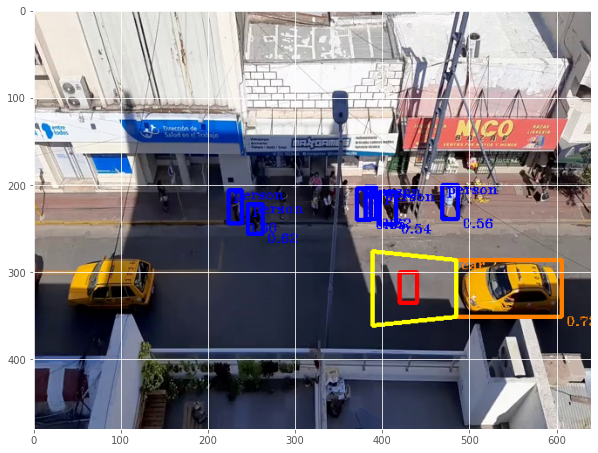

In [23]:
plt.imshow(add_annotations(img, predict_as_df(img, 0.5)))

In [72]:
sqr_to_polygon((420, 340), (440, 375))

[[420, 340], [440, 340], [440, 375], [420, 375]]

In [128]:
col_pts = [[485, 286], [485, 351], [389, 361], [389, 276]]

pt1 = (420, 330)
pt2 = (pt1[0] + 20, pt1[1] + 35)

person_pts = sqr_to_polygon(pt1, pt2)
print(person_pts)

[[420, 330], [440, 330], [440, 365], [420, 365]]


https://towardsdatascience.com/intersection-over-union-iou-calculation-for-evaluating-an-image-segmentation-model-8b22e2e84686

In [14]:
img_test = add_annotations(img, predict_as_df(img, 0.5))

In [154]:
def print_mask(img, bb_points):
    stencil = np.zeros(img.shape).astype(img.dtype)
    contours = [np.array(bb_points)]
    color = [255, 255, 255]
    cv2.fillPoly(stencil, contours, color)
    result1 = cv2.bitwise_and(img, stencil)
    result1 = cv2.cvtColor(result1, cv2.COLOR_BGR2RGB)
    plt.imshow(result1)

In [25]:
col_pts

[[485, 286], [485, 351], [389, 361], [389, 276]]

In [26]:
person_pts

[[420, 300], [440, 300], [440, 335], [420, 335]]

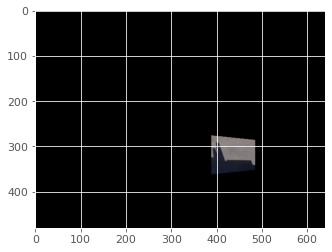

In [155]:
print_mask(img, col_pts)

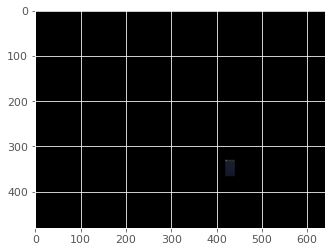

In [174]:
print_mask(img, person_pts)

In [77]:
def IOP(img, collision_pts, person_pts):
    def mask(img, bb_points):
        stencil = np.zeros(img.shape).astype(img.dtype)
        contours = [np.array(bb_points)]
        color = [255, 255, 255]
        result = cv2.fillPoly(stencil, contours, color)
        return cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    
    collision_mask = mask(img, collision_pts)
    person_mask = mask(img, person_pts)
    
    intersection = np.logical_and(collision_mask, person_mask)
    person_region = np.logical_and(person_mask, person_mask)
    iop_score = np.sum(intersection) / np.sum(person_region)
    return iop_score

In [175]:
IOP(img, col_pts, person_pts)

0.7711640211640212

# Prevension Collision Model

In [133]:
class Yolov5():
    
    classes = { "person" : 0, "bicycle" : 1, "car" : 2, "motorcycle" : 3, "bus" : 5 }
    
    def __init__(self, model):
        self.model = model
        
    def predict(self, img, conf_thres):
        results = self.model(img)
        pred_df = pd.DataFrame()
        pred_df["xmin"] = results.xyxy[0][:,0].numpy().astype(np.int16)
        pred_df["ymin"] = results.xyxy[0][:,1].numpy().astype(np.int16)
        pred_df["xmax"] = results.xyxy[0][:,2].numpy().astype(np.int16)
        pred_df["ymax"] = results.xyxy[0][:,3].numpy().astype(np.int16)
        pred_df["confidence"] = results.xyxy[0][:,4].numpy().astype(np.float32)
        pred_df["class"] = results.xyxy[0][:,5].numpy().astype(np.int8)

        pred_df = pred_df[pred_df["class"].isin(Yolov5.classes.values())]
        pred_df = pred_df[pred_df['confidence'] >= conf_thres] 
        pred_df["id"] = np.arange(len(pred_df), dtype=np.int16)
        
        return pred_df
    

In [134]:
class PreventCollision():
    
    def __init__(self, od_model):
        self.od_model = od_model
        
    def detect(self, img, conf_thres, iop_thres):
        height = img.shape[0]
        width = img.shape[1]
        pred_df = self.od_model.predict(img, conf_thres)
        cars = pred_df[pred_df["class"] == self.od_model.classes["car"]]
        people = pred_df[pred_df["class"] == self.od_model.classes["person"]]
        
        collisions = []
        collision_zone_list = [] 
        for _, car in cars.iterrows():
            collision_zone = PreventCollision.get_collision_zone(car["xmin"], car["ymin"], \
                                                                 car["xmax"], car["ymax"], \
                                                                 width, height)
            collision_zone_list.append(collision_zone)
            for _, person in people.iterrows():
                person_pts = PreventCollision.sqr_to_polygon((person["xmin"], person["ymin"]), \
                                                             (person["xmax"], person["ymax"]))
                iop_score = PreventCollision.IOP(img, collision_zone, person_pts)
                if iop_score >= iop_thres:
                    collisions.append({ 
                        "car_id" : int(car["id"]), 
                        "person_id" : int(person["id"]),
                        "iop_score" : iop_score
                    })
                    
        return pred_df, collision_zone_list, collisions

    def get_collision_zone(xmin, ymin, xmax, ymax, width, height,
                           width_col_zone = 0.8, flap = 10):
        length = (xmax - xmin) * width_col_zone
        pt1 = [xmin, ymin]
        pt2 = [xmin, ymin + (ymax-ymin)]
        pt3 = [pt2[0] - length, pt2[1] + flap]
        pt4 = [pt1[0] - length, pt1[1] - flap]
        pts = [pt1, pt2, pt3, pt4]
        
        for pt in pts:
            if pt[0] >= width : pt[0] = width - 1
            if pt[1] >= height : pt[1] = height - 1
            if pt[0] < 0 : pt[0] = 0
            if pt[1] < 0 : pt[1] = 0
        
        pts = [ [ int(pt[0]), int(pt[1]) ] for pt in pts ]

        return pts
    
    def sqr_to_polygon(pt1, pt2): 
        pts = [list(pt1), [pt1[0] + (pt2[0] - pt1[0]), pt1[1]], \
               list(pt2), [pt1[0], pt1[1] + (pt2[1] - pt1[1])]]
        
        pts = [ [ int(pt[0]), int(pt[1]) ] for pt in pts ]
            
        return pts
    
    # Intersection Over Person
    def IOP(img, collision_pts, person_pts):
        def mask(img, bb_points):
            stencil = np.zeros(img.shape).astype(img.dtype)
            contours = [np.array(bb_points)]
            color = [255, 255, 255]
            result = cv2.fillPoly(stencil, contours, color)
            return cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

        collision_mask = mask(img, collision_pts)
        person_mask = mask(img, person_pts)

        intersection = np.logical_and(collision_mask, person_mask)
        person_region = np.logical_and(person_mask, person_mask)
        iop_score = np.sum(intersection) / np.sum(person_region)
        
        return iop_score
    

In [174]:
class VideoWriter():
    
    color_map = {
        "person": (0, 0, 255), # blue
        "bicycle": (0, 255, 255), # cyan 
        "car": (255, 128, 0), # orange 
        "motorcycle": (128, 0, 255), # purple 
        "bus": (255, 0, 255), # magenta
        "collision_zone": (255, 255, 0), # yellow
        "person_in_danger": (255, 0, 0) # red
    }
    
    def __init__(self, pc_model):
        self.pc_model = pc_model 
        
    def add_annotations(self, img, pred_df, collision_zone_list, collisions):
        font = cv2.FONT_HERSHEY_TRIPLEX
        img_ = img.copy()
        
        class_map = { v:k for k,v in self.pc_model.od_model.classes.items() }
        people_danger = [ int(col["person_id"]) for col in collisions ]
        
        # draw the collision zones
        for collision_zone_pts in collision_zone_list:
            pts = np.array(collision_zone_pts, np.int32)
            pts = pts.reshape((-1, 1, 2))
            img_ = cv2.polylines(img_, [pts], True, self.color_map["collision_zone"], 4)

        # draw the bboxes
        for _, pred in pred_df.iterrows():
            xmin, ymin, xmax, ymax = pred["xmin"], pred["ymin"], pred["xmax"], pred["ymax"]

            if pred["id"] in people_danger:
                color = self.color_map["person_in_danger"]
            else:
                color = self.color_map[class_map[pred['class']]]

            pt1 = int(xmin), int(ymin)
            pt2 = int(xmax), int(ymax)
            img_ = cv2.rectangle(img_, pt1, pt2, color, 3)

            pt_text = pt1[0] + 5, pt1[1] + 10
            img_ = cv2.putText(img_, class_map[pred['class']], pt_text, font, 0.5, color)

            confidence_label = f"{pred['confidence']:.2f}"
            pt_conf = pt2[0] + 5, pt2[1] + 10
            img_ = cv2.putText(img_, confidence_label, pt_conf, font, 0.5, color)

        return img_
    
    def generate_video(self, video_path, video_output,
                       width = 640, 
                       height = 480,
                       conf_thres = 0.3,
                       iop_thres = 0.5,
                       video_codec = "mp4v"):
        
        cap = cv2.VideoCapture(video_path)
        n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        out = cv2.VideoWriter(video_output,
            cv2.VideoWriter_fourcc(*video_codec),
            fps,
            (width, height))
        
        for frame in tqdm(range(n_frames), total=n_frames):
            ret, img = cap.read()
            if not ret : break

            pred_df, collision_zone_list, collisions = self.pc_model.detect(img, conf_thres, iop_thres)
            img_ = self.add_annotations(img, pred_df, collision_zone_list, collisions)
            out.write(img_)

        out.release()
        cap.release()

In [131]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x')

Using cache found in /home/maxi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-2-2 Python-3.10.4 torch-1.13.1+cu117 CPU



  0%|          | 0.00/166M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [175]:
# Testing
yolo = Yolov5(model)
pc = PreventCollision(yolo)
vw = VideoWriter(pc)

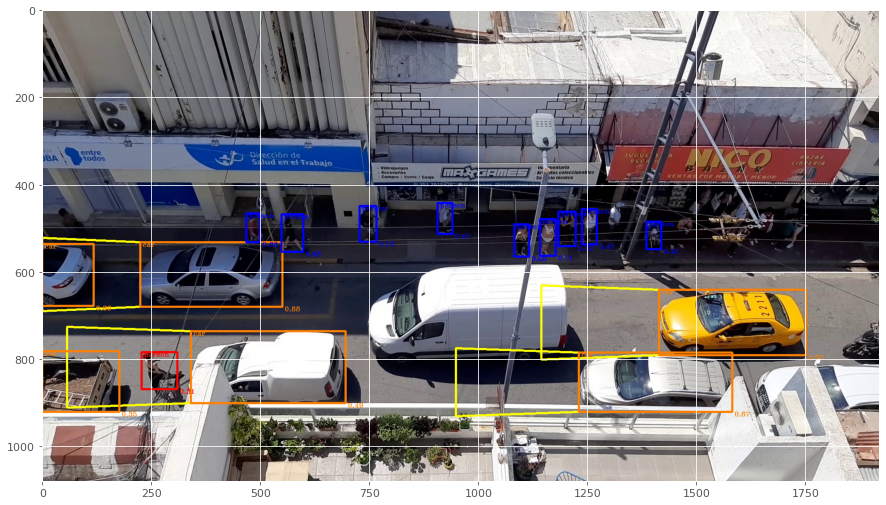

In [129]:
pred_df, collision_zone_list, collisions = pc.detect(img, 0.3, 0.5)
img_test = vw.add_annotations(img, pred_df, collision_zone_list, collisions)
display_img(img_test)

In [130]:
collisions

[{'car_id': 9, 'person_id': 15, 'iop_score': 1.0}]

In [178]:
! ls data/

20230131_115340.mp4	       street0_compresed.mp4  street0_pred_res.mp4
20230131_115340_compresed.mp4  street0_exp.mp4	      street1.mp4
20230131_115340_exp.mp4        street0_pred.mp4
street0.mp4		       street0_pred_comp.mp4


In [180]:
vw.generate_video(
    video_path="./data/20230131_115340_exp.mp4", 
    video_output="./output/20230131_115340_pred_1.mp4",
    width = 640, 
    height = 480,
    conf_thres = 0.3,
    iop_thres = 0.5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1075/1075 [28:33<00:00,  1.59s/it]


In [179]:
get_basic_info("./data/20230131_115340_exp.mp4")

{'width': 640,
 'height': 480,
 'frames': 1075,
 'fps': 30.0,
 'total_seconds': 35.833333333333336}